In [1]:
import pandas as pd
import os
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import  Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, LSTM
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
def load_data(dataset_path='./npy_files'):
    X = np.load(os.path.join(dataset_path,'X.npy'))
    y = np.load(os.path.join(dataset_path,'y.npy'))
    folds = np.load(os.path.join(dataset_path,'folds.npy'))
    feature_class = np.load(os.path.join(dataset_path, 'feature_class.npy'))
    facs = pd.read_csv('save_data/npy_files/facs_multi.csv',index_col=None)

    # rescale [0,255] -> [0,2]    
    X = X.astype('float32')/255*2

    # one-hot encode the labels
    num_classes = len(np.unique(y))
    y = keras.utils.to_categorical(y, num_classes)

    return X, y, folds, feature_class, facs

In [3]:
X, y, folds, feature_class, facs = load_data('./save_data/npy_files/')

In [4]:
del facs['Unnamed: 0']

In [5]:
del facs['10']

In [6]:
del facs['26']

In [7]:
facs

,0,1,2,4,5,6,7,9,12,15,17,20,23,24,25,27
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
feature_class_single = np.zeros((1307, 4040))
for index, inst in enumerate(feature_class):
    feature_class_single[index] = inst[0]

In [10]:
feature_train, feature_test, facs_train, facs_test = \
        train_test_split(feature_class_single, facs, test_size=0.2)

In [11]:
def make_model():
    inputs = Input(shape=(4040,))
    h1 = Dense(1000, activation='relu')(inputs)
    h2 = Dense(500, activation='relu')(inputs)
    prediction = Dense(16, activation='sigmoid')(h2)
    
    dense_model = Model(inputs=inputs, outputs=prediction)
    sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9)
    dense_model.compile(loss='binary_crossentropy', optimizer=sgd,
             metrics=['accuracy'])
    
    return dense_model

In [40]:
dense_model = make_model()

In [41]:
hist = dense_model.fit(feature_train, facs_train, batch_size=64, epochs=4000,
            validation_data=(feature_test, facs_test),
            verbose=2, shuffle=True)

Train on 1045 samples, validate on 262 samples
Epoch 1/4000
 - 0s - loss: 0.8770 - acc: 0.4365 - val_loss: 0.8114 - val_acc: 0.4757
Epoch 2/4000
 - 0s - loss: 0.7685 - acc: 0.5059 - val_loss: 0.7048 - val_acc: 0.5611
Epoch 3/4000
 - 0s - loss: 0.6719 - acc: 0.5940 - val_loss: 0.6287 - val_acc: 0.6477
Epoch 4/4000
 - 0s - loss: 0.6069 - acc: 0.6704 - val_loss: 0.5787 - val_acc: 0.7135
Epoch 5/4000
 - 0s - loss: 0.5642 - acc: 0.7240 - val_loss: 0.5455 - val_acc: 0.7519
Epoch 6/4000
 - 0s - loss: 0.5357 - acc: 0.7562 - val_loss: 0.5225 - val_acc: 0.7719
Epoch 7/4000
 - 0s - loss: 0.5154 - acc: 0.7738 - val_loss: 0.5058 - val_acc: 0.7822
Epoch 8/4000
 - 0s - loss: 0.5005 - acc: 0.7837 - val_loss: 0.4933 - val_acc: 0.7898
Epoch 9/4000
 - 0s - loss: 0.4890 - acc: 0.7894 - val_loss: 0.4834 - val_acc: 0.7946
Epoch 10/4000
 - 0s - loss: 0.4798 - acc: 0.7943 - val_loss: 0.4749 - val_acc: 0.7972
Epoch 11/4000
 - 0s - loss: 0.4719 - acc: 0.7981 - val_loss: 0.4681 - val_acc: 0.8010
Epoch 12/4000
 -

Epoch 96/4000
 - 0s - loss: 0.2930 - acc: 0.8937 - val_loss: 0.2983 - val_acc: 0.8915
Epoch 97/4000
 - 0s - loss: 0.2921 - acc: 0.8940 - val_loss: 0.2974 - val_acc: 0.8927
Epoch 98/4000
 - 0s - loss: 0.2911 - acc: 0.8946 - val_loss: 0.2965 - val_acc: 0.8927
Epoch 99/4000
 - 0s - loss: 0.2902 - acc: 0.8950 - val_loss: 0.2955 - val_acc: 0.8936
Epoch 100/4000
 - 0s - loss: 0.2893 - acc: 0.8952 - val_loss: 0.2947 - val_acc: 0.8938
Epoch 101/4000
 - 0s - loss: 0.2884 - acc: 0.8956 - val_loss: 0.2938 - val_acc: 0.8946
Epoch 102/4000
 - 0s - loss: 0.2875 - acc: 0.8957 - val_loss: 0.2929 - val_acc: 0.8950
Epoch 103/4000
 - 0s - loss: 0.2865 - acc: 0.8956 - val_loss: 0.2920 - val_acc: 0.8958
Epoch 104/4000
 - 0s - loss: 0.2857 - acc: 0.8960 - val_loss: 0.2912 - val_acc: 0.8965
Epoch 105/4000
 - 0s - loss: 0.2848 - acc: 0.8964 - val_loss: 0.2903 - val_acc: 0.8969
Epoch 106/4000
 - 0s - loss: 0.2839 - acc: 0.8968 - val_loss: 0.2895 - val_acc: 0.8972
Epoch 107/4000
 - 0s - loss: 0.2831 - acc: 0.89

Epoch 191/4000
 - 0s - loss: 0.2328 - acc: 0.9166 - val_loss: 0.2413 - val_acc: 0.9117
Epoch 192/4000
 - 0s - loss: 0.2324 - acc: 0.9167 - val_loss: 0.2409 - val_acc: 0.9117
Epoch 193/4000
 - 0s - loss: 0.2319 - acc: 0.9170 - val_loss: 0.2405 - val_acc: 0.9117
Epoch 194/4000
 - 0s - loss: 0.2315 - acc: 0.9169 - val_loss: 0.2400 - val_acc: 0.9117
Epoch 195/4000
 - 0s - loss: 0.2311 - acc: 0.9171 - val_loss: 0.2397 - val_acc: 0.9117
Epoch 196/4000
 - 0s - loss: 0.2307 - acc: 0.9174 - val_loss: 0.2393 - val_acc: 0.9122
Epoch 197/4000
 - 0s - loss: 0.2303 - acc: 0.9176 - val_loss: 0.2389 - val_acc: 0.9122
Epoch 198/4000
 - 0s - loss: 0.2299 - acc: 0.9179 - val_loss: 0.2386 - val_acc: 0.9122
Epoch 199/4000
 - 0s - loss: 0.2295 - acc: 0.9180 - val_loss: 0.2382 - val_acc: 0.9127
Epoch 200/4000
 - 0s - loss: 0.2291 - acc: 0.9180 - val_loss: 0.2378 - val_acc: 0.9127
Epoch 201/4000
 - 0s - loss: 0.2287 - acc: 0.9182 - val_loss: 0.2374 - val_acc: 0.9127
Epoch 202/4000
 - 0s - loss: 0.2283 - acc: 

 - 0s - loss: 0.2018 - acc: 0.9287 - val_loss: 0.2129 - val_acc: 0.9225
Epoch 286/4000
 - 0s - loss: 0.2016 - acc: 0.9285 - val_loss: 0.2127 - val_acc: 0.9229
Epoch 287/4000
 - 0s - loss: 0.2013 - acc: 0.9288 - val_loss: 0.2125 - val_acc: 0.9234
Epoch 288/4000
 - 0s - loss: 0.2011 - acc: 0.9289 - val_loss: 0.2122 - val_acc: 0.9232
Epoch 289/4000
 - 0s - loss: 0.2008 - acc: 0.9291 - val_loss: 0.2120 - val_acc: 0.9234
Epoch 290/4000
 - 0s - loss: 0.2006 - acc: 0.9293 - val_loss: 0.2118 - val_acc: 0.9237
Epoch 291/4000
 - 0s - loss: 0.2003 - acc: 0.9292 - val_loss: 0.2115 - val_acc: 0.9239
Epoch 292/4000
 - 0s - loss: 0.2001 - acc: 0.9293 - val_loss: 0.2113 - val_acc: 0.9239
Epoch 293/4000
 - 0s - loss: 0.1998 - acc: 0.9293 - val_loss: 0.2111 - val_acc: 0.9239
Epoch 294/4000
 - 0s - loss: 0.1996 - acc: 0.9295 - val_loss: 0.2109 - val_acc: 0.9239
Epoch 295/4000
 - 0s - loss: 0.1993 - acc: 0.9294 - val_loss: 0.2106 - val_acc: 0.9239
Epoch 296/4000
 - 0s - loss: 0.1991 - acc: 0.9296 - val_lo

Epoch 380/4000
 - 0s - loss: 0.1812 - acc: 0.9369 - val_loss: 0.1946 - val_acc: 0.9299
Epoch 381/4000
 - 0s - loss: 0.1810 - acc: 0.9369 - val_loss: 0.1945 - val_acc: 0.9296
Epoch 382/4000
 - 0s - loss: 0.1808 - acc: 0.9368 - val_loss: 0.1943 - val_acc: 0.9296
Epoch 383/4000
 - 0s - loss: 0.1806 - acc: 0.9371 - val_loss: 0.1941 - val_acc: 0.9296
Epoch 384/4000
 - 0s - loss: 0.1805 - acc: 0.9371 - val_loss: 0.1940 - val_acc: 0.9296
Epoch 385/4000
 - 0s - loss: 0.1803 - acc: 0.9371 - val_loss: 0.1938 - val_acc: 0.9299
Epoch 386/4000
 - 0s - loss: 0.1801 - acc: 0.9371 - val_loss: 0.1937 - val_acc: 0.9299
Epoch 387/4000
 - 0s - loss: 0.1799 - acc: 0.9371 - val_loss: 0.1935 - val_acc: 0.9296
Epoch 388/4000
 - 0s - loss: 0.1797 - acc: 0.9374 - val_loss: 0.1934 - val_acc: 0.9303
Epoch 389/4000
 - 0s - loss: 0.1796 - acc: 0.9374 - val_loss: 0.1932 - val_acc: 0.9303
Epoch 390/4000
 - 0s - loss: 0.1794 - acc: 0.9374 - val_loss: 0.1931 - val_acc: 0.9303
Epoch 391/4000
 - 0s - loss: 0.1792 - acc: 

 - 0s - loss: 0.1661 - acc: 0.9426 - val_loss: 0.1818 - val_acc: 0.9332
Epoch 475/4000
 - 0s - loss: 0.1659 - acc: 0.9425 - val_loss: 0.1816 - val_acc: 0.9332
Epoch 476/4000
 - 0s - loss: 0.1658 - acc: 0.9425 - val_loss: 0.1815 - val_acc: 0.9332
Epoch 477/4000
 - 0s - loss: 0.1656 - acc: 0.9425 - val_loss: 0.1814 - val_acc: 0.9332
Epoch 478/4000
 - 0s - loss: 0.1655 - acc: 0.9426 - val_loss: 0.1813 - val_acc: 0.9332
Epoch 479/4000
 - 0s - loss: 0.1654 - acc: 0.9426 - val_loss: 0.1812 - val_acc: 0.9332
Epoch 480/4000
 - 0s - loss: 0.1652 - acc: 0.9427 - val_loss: 0.1811 - val_acc: 0.9332
Epoch 481/4000
 - 0s - loss: 0.1651 - acc: 0.9428 - val_loss: 0.1809 - val_acc: 0.9332
Epoch 482/4000
 - 0s - loss: 0.1649 - acc: 0.9428 - val_loss: 0.1808 - val_acc: 0.9332
Epoch 483/4000
 - 0s - loss: 0.1648 - acc: 0.9428 - val_loss: 0.1807 - val_acc: 0.9332
Epoch 484/4000
 - 0s - loss: 0.1647 - acc: 0.9428 - val_loss: 0.1806 - val_acc: 0.9332
Epoch 485/4000
 - 0s - loss: 0.1645 - acc: 0.9429 - val_lo

Epoch 569/4000
 - 0s - loss: 0.1541 - acc: 0.9482 - val_loss: 0.1718 - val_acc: 0.9363
Epoch 570/4000
 - 0s - loss: 0.1539 - acc: 0.9483 - val_loss: 0.1717 - val_acc: 0.9363
Epoch 571/4000
 - 0s - loss: 0.1538 - acc: 0.9481 - val_loss: 0.1716 - val_acc: 0.9365
Epoch 572/4000
 - 0s - loss: 0.1537 - acc: 0.9481 - val_loss: 0.1715 - val_acc: 0.9365
Epoch 573/4000
 - 0s - loss: 0.1536 - acc: 0.9481 - val_loss: 0.1714 - val_acc: 0.9365
Epoch 574/4000
 - 0s - loss: 0.1535 - acc: 0.9483 - val_loss: 0.1714 - val_acc: 0.9368
Epoch 575/4000
 - 0s - loss: 0.1534 - acc: 0.9484 - val_loss: 0.1713 - val_acc: 0.9368
Epoch 576/4000
 - 0s - loss: 0.1533 - acc: 0.9486 - val_loss: 0.1712 - val_acc: 0.9368
Epoch 577/4000
 - 0s - loss: 0.1532 - acc: 0.9487 - val_loss: 0.1711 - val_acc: 0.9370
Epoch 578/4000
 - 0s - loss: 0.1530 - acc: 0.9487 - val_loss: 0.1710 - val_acc: 0.9370
Epoch 579/4000
 - 0s - loss: 0.1529 - acc: 0.9487 - val_loss: 0.1709 - val_acc: 0.9370
Epoch 580/4000
 - 0s - loss: 0.1528 - acc: 

 - 0s - loss: 0.1443 - acc: 0.9521 - val_loss: 0.1639 - val_acc: 0.9392
Epoch 664/4000
 - 0s - loss: 0.1442 - acc: 0.9521 - val_loss: 0.1638 - val_acc: 0.9392
Epoch 665/4000
 - 0s - loss: 0.1441 - acc: 0.9522 - val_loss: 0.1637 - val_acc: 0.9396
Epoch 666/4000
 - 0s - loss: 0.1440 - acc: 0.9523 - val_loss: 0.1636 - val_acc: 0.9394
Epoch 667/4000
 - 0s - loss: 0.1439 - acc: 0.9522 - val_loss: 0.1636 - val_acc: 0.9396
Epoch 668/4000
 - 0s - loss: 0.1438 - acc: 0.9522 - val_loss: 0.1635 - val_acc: 0.9396
Epoch 669/4000
 - 0s - loss: 0.1438 - acc: 0.9523 - val_loss: 0.1634 - val_acc: 0.9394
Epoch 670/4000
 - 0s - loss: 0.1437 - acc: 0.9523 - val_loss: 0.1633 - val_acc: 0.9394
Epoch 671/4000
 - 0s - loss: 0.1436 - acc: 0.9524 - val_loss: 0.1633 - val_acc: 0.9396
Epoch 672/4000
 - 0s - loss: 0.1435 - acc: 0.9523 - val_loss: 0.1632 - val_acc: 0.9396
Epoch 673/4000
 - 0s - loss: 0.1434 - acc: 0.9523 - val_loss: 0.1632 - val_acc: 0.9399
Epoch 674/4000
 - 0s - loss: 0.1433 - acc: 0.9523 - val_lo

Epoch 758/4000
 - 0s - loss: 0.1360 - acc: 0.9547 - val_loss: 0.1572 - val_acc: 0.9423
Epoch 759/4000
 - 0s - loss: 0.1359 - acc: 0.9547 - val_loss: 0.1572 - val_acc: 0.9425
Epoch 760/4000
 - 0s - loss: 0.1359 - acc: 0.9548 - val_loss: 0.1571 - val_acc: 0.9425
Epoch 761/4000
 - 0s - loss: 0.1358 - acc: 0.9548 - val_loss: 0.1570 - val_acc: 0.9425
Epoch 762/4000
 - 0s - loss: 0.1357 - acc: 0.9548 - val_loss: 0.1570 - val_acc: 0.9425
Epoch 763/4000
 - 0s - loss: 0.1356 - acc: 0.9550 - val_loss: 0.1569 - val_acc: 0.9423
Epoch 764/4000
 - 0s - loss: 0.1355 - acc: 0.9550 - val_loss: 0.1568 - val_acc: 0.9427
Epoch 765/4000
 - 0s - loss: 0.1355 - acc: 0.9550 - val_loss: 0.1568 - val_acc: 0.9423
Epoch 766/4000
 - 0s - loss: 0.1354 - acc: 0.9550 - val_loss: 0.1567 - val_acc: 0.9425
Epoch 767/4000
 - 0s - loss: 0.1353 - acc: 0.9551 - val_loss: 0.1567 - val_acc: 0.9427
Epoch 768/4000
 - 0s - loss: 0.1352 - acc: 0.9551 - val_loss: 0.1566 - val_acc: 0.9427
Epoch 769/4000
 - 0s - loss: 0.1351 - acc: 

 - 0s - loss: 0.1289 - acc: 0.9579 - val_loss: 0.1516 - val_acc: 0.9451
Epoch 853/4000
 - 0s - loss: 0.1289 - acc: 0.9579 - val_loss: 0.1515 - val_acc: 0.9451
Epoch 854/4000
 - 0s - loss: 0.1288 - acc: 0.9579 - val_loss: 0.1515 - val_acc: 0.9451
Epoch 855/4000
 - 0s - loss: 0.1287 - acc: 0.9578 - val_loss: 0.1514 - val_acc: 0.9451
Epoch 856/4000
 - 0s - loss: 0.1287 - acc: 0.9580 - val_loss: 0.1514 - val_acc: 0.9451
Epoch 857/4000
 - 0s - loss: 0.1286 - acc: 0.9580 - val_loss: 0.1513 - val_acc: 0.9451
Epoch 858/4000
 - 0s - loss: 0.1285 - acc: 0.9580 - val_loss: 0.1513 - val_acc: 0.9451
Epoch 859/4000
 - 0s - loss: 0.1285 - acc: 0.9581 - val_loss: 0.1512 - val_acc: 0.9451
Epoch 860/4000
 - 0s - loss: 0.1284 - acc: 0.9582 - val_loss: 0.1511 - val_acc: 0.9454
Epoch 861/4000
 - 0s - loss: 0.1283 - acc: 0.9581 - val_loss: 0.1511 - val_acc: 0.9456
Epoch 862/4000
 - 0s - loss: 0.1282 - acc: 0.9582 - val_loss: 0.1510 - val_acc: 0.9454
Epoch 863/4000
 - 0s - loss: 0.1282 - acc: 0.9582 - val_lo

Epoch 947/4000
 - 0s - loss: 0.1227 - acc: 0.9600 - val_loss: 0.1466 - val_acc: 0.9478
Epoch 948/4000
 - 0s - loss: 0.1226 - acc: 0.9600 - val_loss: 0.1465 - val_acc: 0.9478
Epoch 949/4000
 - 0s - loss: 0.1226 - acc: 0.9600 - val_loss: 0.1465 - val_acc: 0.9475
Epoch 950/4000
 - 0s - loss: 0.1225 - acc: 0.9601 - val_loss: 0.1464 - val_acc: 0.9480
Epoch 951/4000
 - 0s - loss: 0.1224 - acc: 0.9602 - val_loss: 0.1464 - val_acc: 0.9480
Epoch 952/4000
 - 0s - loss: 0.1224 - acc: 0.9603 - val_loss: 0.1463 - val_acc: 0.9480
Epoch 953/4000
 - 0s - loss: 0.1223 - acc: 0.9602 - val_loss: 0.1463 - val_acc: 0.9480
Epoch 954/4000
 - 0s - loss: 0.1223 - acc: 0.9602 - val_loss: 0.1462 - val_acc: 0.9482
Epoch 955/4000
 - 0s - loss: 0.1222 - acc: 0.9601 - val_loss: 0.1462 - val_acc: 0.9480
Epoch 956/4000
 - 0s - loss: 0.1221 - acc: 0.9602 - val_loss: 0.1461 - val_acc: 0.9480
Epoch 957/4000
 - 0s - loss: 0.1221 - acc: 0.9602 - val_loss: 0.1461 - val_acc: 0.9482
Epoch 958/4000
 - 0s - loss: 0.1220 - acc: 

Epoch 1041/4000
 - 0s - loss: 0.1172 - acc: 0.9618 - val_loss: 0.1422 - val_acc: 0.9485
Epoch 1042/4000
 - 0s - loss: 0.1172 - acc: 0.9618 - val_loss: 0.1421 - val_acc: 0.9487
Epoch 1043/4000
 - 0s - loss: 0.1171 - acc: 0.9618 - val_loss: 0.1420 - val_acc: 0.9492
Epoch 1044/4000
 - 0s - loss: 0.1170 - acc: 0.9618 - val_loss: 0.1420 - val_acc: 0.9494
Epoch 1045/4000
 - 0s - loss: 0.1170 - acc: 0.9618 - val_loss: 0.1419 - val_acc: 0.9492
Epoch 1046/4000
 - 0s - loss: 0.1169 - acc: 0.9618 - val_loss: 0.1419 - val_acc: 0.9492
Epoch 1047/4000
 - 0s - loss: 0.1169 - acc: 0.9620 - val_loss: 0.1419 - val_acc: 0.9492
Epoch 1048/4000
 - 0s - loss: 0.1168 - acc: 0.9621 - val_loss: 0.1418 - val_acc: 0.9492
Epoch 1049/4000
 - 0s - loss: 0.1168 - acc: 0.9621 - val_loss: 0.1418 - val_acc: 0.9490
Epoch 1050/4000
 - 0s - loss: 0.1167 - acc: 0.9621 - val_loss: 0.1417 - val_acc: 0.9490
Epoch 1051/4000
 - 0s - loss: 0.1167 - acc: 0.9622 - val_loss: 0.1417 - val_acc: 0.9490
Epoch 1052/4000
 - 0s - loss: 0.

 - 0s - loss: 0.1123 - acc: 0.9641 - val_loss: 0.1382 - val_acc: 0.9492
Epoch 1135/4000
 - 0s - loss: 0.1123 - acc: 0.9640 - val_loss: 0.1382 - val_acc: 0.9490
Epoch 1136/4000
 - 0s - loss: 0.1122 - acc: 0.9641 - val_loss: 0.1381 - val_acc: 0.9492
Epoch 1137/4000
 - 0s - loss: 0.1122 - acc: 0.9641 - val_loss: 0.1381 - val_acc: 0.9492
Epoch 1138/4000
 - 0s - loss: 0.1121 - acc: 0.9641 - val_loss: 0.1381 - val_acc: 0.9492
Epoch 1139/4000
 - 0s - loss: 0.1121 - acc: 0.9641 - val_loss: 0.1380 - val_acc: 0.9492
Epoch 1140/4000
 - 0s - loss: 0.1120 - acc: 0.9642 - val_loss: 0.1380 - val_acc: 0.9492
Epoch 1141/4000
 - 0s - loss: 0.1120 - acc: 0.9642 - val_loss: 0.1380 - val_acc: 0.9492
Epoch 1142/4000
 - 0s - loss: 0.1119 - acc: 0.9642 - val_loss: 0.1379 - val_acc: 0.9492
Epoch 1143/4000
 - 0s - loss: 0.1119 - acc: 0.9641 - val_loss: 0.1379 - val_acc: 0.9492
Epoch 1144/4000
 - 0s - loss: 0.1118 - acc: 0.9642 - val_loss: 0.1378 - val_acc: 0.9492
Epoch 1145/4000
 - 0s - loss: 0.1118 - acc: 0.96

Epoch 1228/4000
 - 0s - loss: 0.1079 - acc: 0.9659 - val_loss: 0.1345 - val_acc: 0.9494
Epoch 1229/4000
 - 0s - loss: 0.1078 - acc: 0.9659 - val_loss: 0.1345 - val_acc: 0.9494
Epoch 1230/4000
 - 0s - loss: 0.1078 - acc: 0.9659 - val_loss: 0.1345 - val_acc: 0.9494
Epoch 1231/4000
 - 0s - loss: 0.1077 - acc: 0.9659 - val_loss: 0.1344 - val_acc: 0.9497
Epoch 1232/4000
 - 0s - loss: 0.1077 - acc: 0.9659 - val_loss: 0.1344 - val_acc: 0.9494
Epoch 1233/4000
 - 0s - loss: 0.1077 - acc: 0.9661 - val_loss: 0.1344 - val_acc: 0.9494
Epoch 1234/4000
 - 0s - loss: 0.1076 - acc: 0.9660 - val_loss: 0.1343 - val_acc: 0.9494
Epoch 1235/4000
 - 0s - loss: 0.1076 - acc: 0.9661 - val_loss: 0.1343 - val_acc: 0.9494
Epoch 1236/4000
 - 0s - loss: 0.1075 - acc: 0.9661 - val_loss: 0.1343 - val_acc: 0.9497
Epoch 1237/4000
 - 0s - loss: 0.1075 - acc: 0.9661 - val_loss: 0.1342 - val_acc: 0.9494
Epoch 1238/4000
 - 0s - loss: 0.1074 - acc: 0.9663 - val_loss: 0.1342 - val_acc: 0.9494
Epoch 1239/4000
 - 0s - loss: 0.

 - 0s - loss: 0.1039 - acc: 0.9676 - val_loss: 0.1312 - val_acc: 0.9513
Epoch 1322/4000
 - 0s - loss: 0.1038 - acc: 0.9678 - val_loss: 0.1312 - val_acc: 0.9513
Epoch 1323/4000
 - 0s - loss: 0.1038 - acc: 0.9677 - val_loss: 0.1312 - val_acc: 0.9518
Epoch 1324/4000
 - 0s - loss: 0.1037 - acc: 0.9677 - val_loss: 0.1311 - val_acc: 0.9516
Epoch 1325/4000
 - 0s - loss: 0.1037 - acc: 0.9677 - val_loss: 0.1311 - val_acc: 0.9516
Epoch 1326/4000
 - 0s - loss: 0.1037 - acc: 0.9678 - val_loss: 0.1311 - val_acc: 0.9513
Epoch 1327/4000
 - 0s - loss: 0.1036 - acc: 0.9678 - val_loss: 0.1310 - val_acc: 0.9518
Epoch 1328/4000
 - 0s - loss: 0.1036 - acc: 0.9678 - val_loss: 0.1310 - val_acc: 0.9516
Epoch 1329/4000
 - 0s - loss: 0.1035 - acc: 0.9677 - val_loss: 0.1310 - val_acc: 0.9516
Epoch 1330/4000
 - 0s - loss: 0.1035 - acc: 0.9678 - val_loss: 0.1310 - val_acc: 0.9516
Epoch 1331/4000
 - 0s - loss: 0.1035 - acc: 0.9678 - val_loss: 0.1309 - val_acc: 0.9518
Epoch 1332/4000
 - 0s - loss: 0.1034 - acc: 0.96

Epoch 1415/4000
 - 0s - loss: 0.1001 - acc: 0.9689 - val_loss: 0.1282 - val_acc: 0.9523
Epoch 1416/4000
 - 0s - loss: 0.1001 - acc: 0.9690 - val_loss: 0.1281 - val_acc: 0.9523
Epoch 1417/4000
 - 0s - loss: 0.1001 - acc: 0.9690 - val_loss: 0.1281 - val_acc: 0.9523
Epoch 1418/4000
 - 0s - loss: 0.1000 - acc: 0.9690 - val_loss: 0.1281 - val_acc: 0.9523
Epoch 1419/4000
 - 0s - loss: 0.1000 - acc: 0.9690 - val_loss: 0.1281 - val_acc: 0.9523
Epoch 1420/4000
 - 0s - loss: 0.0999 - acc: 0.9690 - val_loss: 0.1280 - val_acc: 0.9523
Epoch 1421/4000
 - 0s - loss: 0.0999 - acc: 0.9690 - val_loss: 0.1280 - val_acc: 0.9521
Epoch 1422/4000
 - 0s - loss: 0.0999 - acc: 0.9690 - val_loss: 0.1280 - val_acc: 0.9523
Epoch 1423/4000
 - 0s - loss: 0.0998 - acc: 0.9692 - val_loss: 0.1279 - val_acc: 0.9523
Epoch 1424/4000
 - 0s - loss: 0.0998 - acc: 0.9691 - val_loss: 0.1279 - val_acc: 0.9521
Epoch 1425/4000
 - 0s - loss: 0.0998 - acc: 0.9691 - val_loss: 0.1278 - val_acc: 0.9521
Epoch 1426/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0967 - acc: 0.9709 - val_loss: 0.1254 - val_acc: 0.9523
Epoch 1509/4000
 - 0s - loss: 0.0967 - acc: 0.9708 - val_loss: 0.1254 - val_acc: 0.9523
Epoch 1510/4000
 - 0s - loss: 0.0967 - acc: 0.9709 - val_loss: 0.1253 - val_acc: 0.9525
Epoch 1511/4000
 - 0s - loss: 0.0966 - acc: 0.9708 - val_loss: 0.1253 - val_acc: 0.9523
Epoch 1512/4000
 - 0s - loss: 0.0966 - acc: 0.9709 - val_loss: 0.1253 - val_acc: 0.9523
Epoch 1513/4000
 - 0s - loss: 0.0966 - acc: 0.9709 - val_loss: 0.1252 - val_acc: 0.9523
Epoch 1514/4000
 - 0s - loss: 0.0965 - acc: 0.9711 - val_loss: 0.1252 - val_acc: 0.9523
Epoch 1515/4000
 - 0s - loss: 0.0965 - acc: 0.9711 - val_loss: 0.1252 - val_acc: 0.9525
Epoch 1516/4000
 - 0s - loss: 0.0965 - acc: 0.9711 - val_loss: 0.1252 - val_acc: 0.9525
Epoch 1517/4000
 - 0s - loss: 0.0964 - acc: 0.9710 - val_loss: 0.1251 - val_acc: 0.9523
Epoch 1518/4000
 - 0s - loss: 0.0964 - acc: 0.9711 - val_loss: 0.1251 - val_acc: 0.9523
Epoch 1519/4000
 - 0s - loss: 0.0964 - acc: 0.97

Epoch 1602/4000
 - 0s - loss: 0.0936 - acc: 0.9724 - val_loss: 0.1227 - val_acc: 0.9535
Epoch 1603/4000
 - 0s - loss: 0.0935 - acc: 0.9724 - val_loss: 0.1227 - val_acc: 0.9535
Epoch 1604/4000
 - 0s - loss: 0.0935 - acc: 0.9725 - val_loss: 0.1226 - val_acc: 0.9535
Epoch 1605/4000
 - 0s - loss: 0.0935 - acc: 0.9725 - val_loss: 0.1226 - val_acc: 0.9535
Epoch 1606/4000
 - 0s - loss: 0.0935 - acc: 0.9725 - val_loss: 0.1226 - val_acc: 0.9535
Epoch 1607/4000
 - 0s - loss: 0.0934 - acc: 0.9726 - val_loss: 0.1226 - val_acc: 0.9535
Epoch 1608/4000
 - 0s - loss: 0.0934 - acc: 0.9727 - val_loss: 0.1225 - val_acc: 0.9535
Epoch 1609/4000
 - 0s - loss: 0.0934 - acc: 0.9727 - val_loss: 0.1225 - val_acc: 0.9535
Epoch 1610/4000
 - 0s - loss: 0.0933 - acc: 0.9725 - val_loss: 0.1225 - val_acc: 0.9535
Epoch 1611/4000
 - 0s - loss: 0.0933 - acc: 0.9727 - val_loss: 0.1225 - val_acc: 0.9535
Epoch 1612/4000
 - 0s - loss: 0.0933 - acc: 0.9725 - val_loss: 0.1224 - val_acc: 0.9535
Epoch 1613/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0907 - acc: 0.9738 - val_loss: 0.1203 - val_acc: 0.9549
Epoch 1696/4000
 - 0s - loss: 0.0906 - acc: 0.9739 - val_loss: 0.1202 - val_acc: 0.9549
Epoch 1697/4000
 - 0s - loss: 0.0906 - acc: 0.9739 - val_loss: 0.1202 - val_acc: 0.9552
Epoch 1698/4000
 - 0s - loss: 0.0906 - acc: 0.9739 - val_loss: 0.1202 - val_acc: 0.9549
Epoch 1699/4000
 - 0s - loss: 0.0905 - acc: 0.9739 - val_loss: 0.1202 - val_acc: 0.9549
Epoch 1700/4000
 - 0s - loss: 0.0905 - acc: 0.9739 - val_loss: 0.1201 - val_acc: 0.9549
Epoch 1701/4000
 - 0s - loss: 0.0905 - acc: 0.9738 - val_loss: 0.1201 - val_acc: 0.9549
Epoch 1702/4000
 - 0s - loss: 0.0905 - acc: 0.9739 - val_loss: 0.1201 - val_acc: 0.9549
Epoch 1703/4000
 - 0s - loss: 0.0904 - acc: 0.9739 - val_loss: 0.1201 - val_acc: 0.9549
Epoch 1704/4000
 - 0s - loss: 0.0904 - acc: 0.9739 - val_loss: 0.1201 - val_acc: 0.9549
Epoch 1705/4000
 - 0s - loss: 0.0904 - acc: 0.9739 - val_loss: 0.1200 - val_acc: 0.9549
Epoch 1706/4000
 - 0s - loss: 0.0903 - acc: 0.97

Epoch 1789/4000
 - 0s - loss: 0.0879 - acc: 0.9749 - val_loss: 0.1179 - val_acc: 0.9561
Epoch 1790/4000
 - 0s - loss: 0.0879 - acc: 0.9749 - val_loss: 0.1179 - val_acc: 0.9561
Epoch 1791/4000
 - 0s - loss: 0.0879 - acc: 0.9750 - val_loss: 0.1179 - val_acc: 0.9561
Epoch 1792/4000
 - 0s - loss: 0.0878 - acc: 0.9749 - val_loss: 0.1179 - val_acc: 0.9561
Epoch 1793/4000
 - 0s - loss: 0.0878 - acc: 0.9750 - val_loss: 0.1179 - val_acc: 0.9561
Epoch 1794/4000
 - 0s - loss: 0.0878 - acc: 0.9751 - val_loss: 0.1178 - val_acc: 0.9561
Epoch 1795/4000
 - 0s - loss: 0.0878 - acc: 0.9751 - val_loss: 0.1178 - val_acc: 0.9561
Epoch 1796/4000
 - 0s - loss: 0.0877 - acc: 0.9750 - val_loss: 0.1178 - val_acc: 0.9561
Epoch 1797/4000
 - 0s - loss: 0.0877 - acc: 0.9751 - val_loss: 0.1177 - val_acc: 0.9561
Epoch 1798/4000
 - 0s - loss: 0.0877 - acc: 0.9751 - val_loss: 0.1177 - val_acc: 0.9561
Epoch 1799/4000
 - 0s - loss: 0.0876 - acc: 0.9751 - val_loss: 0.1177 - val_acc: 0.9563
Epoch 1800/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0854 - acc: 0.9758 - val_loss: 0.1158 - val_acc: 0.9568
Epoch 1883/4000
 - 0s - loss: 0.0854 - acc: 0.9758 - val_loss: 0.1158 - val_acc: 0.9568
Epoch 1884/4000
 - 0s - loss: 0.0853 - acc: 0.9758 - val_loss: 0.1158 - val_acc: 0.9568
Epoch 1885/4000
 - 0s - loss: 0.0853 - acc: 0.9758 - val_loss: 0.1158 - val_acc: 0.9568
Epoch 1886/4000
 - 0s - loss: 0.0853 - acc: 0.9758 - val_loss: 0.1157 - val_acc: 0.9568
Epoch 1887/4000
 - 0s - loss: 0.0853 - acc: 0.9759 - val_loss: 0.1157 - val_acc: 0.9566
Epoch 1888/4000
 - 0s - loss: 0.0852 - acc: 0.9759 - val_loss: 0.1157 - val_acc: 0.9568
Epoch 1889/4000
 - 0s - loss: 0.0852 - acc: 0.9760 - val_loss: 0.1157 - val_acc: 0.9568
Epoch 1890/4000
 - 0s - loss: 0.0852 - acc: 0.9760 - val_loss: 0.1156 - val_acc: 0.9568
Epoch 1891/4000
 - 0s - loss: 0.0851 - acc: 0.9760 - val_loss: 0.1156 - val_acc: 0.9568
Epoch 1892/4000
 - 0s - loss: 0.0851 - acc: 0.9760 - val_loss: 0.1156 - val_acc: 0.9571
Epoch 1893/4000
 - 0s - loss: 0.0851 - acc: 0.97

Epoch 1976/4000
 - 0s - loss: 0.0830 - acc: 0.9766 - val_loss: 0.1137 - val_acc: 0.9580
Epoch 1977/4000
 - 0s - loss: 0.0830 - acc: 0.9766 - val_loss: 0.1137 - val_acc: 0.9580
Epoch 1978/4000
 - 0s - loss: 0.0829 - acc: 0.9767 - val_loss: 0.1137 - val_acc: 0.9580
Epoch 1979/4000
 - 0s - loss: 0.0829 - acc: 0.9767 - val_loss: 0.1137 - val_acc: 0.9580
Epoch 1980/4000
 - 0s - loss: 0.0829 - acc: 0.9767 - val_loss: 0.1137 - val_acc: 0.9580
Epoch 1981/4000
 - 0s - loss: 0.0829 - acc: 0.9767 - val_loss: 0.1136 - val_acc: 0.9580
Epoch 1982/4000
 - 0s - loss: 0.0828 - acc: 0.9767 - val_loss: 0.1136 - val_acc: 0.9580
Epoch 1983/4000
 - 0s - loss: 0.0828 - acc: 0.9767 - val_loss: 0.1136 - val_acc: 0.9580
Epoch 1984/4000
 - 0s - loss: 0.0828 - acc: 0.9767 - val_loss: 0.1136 - val_acc: 0.9580
Epoch 1985/4000
 - 0s - loss: 0.0828 - acc: 0.9767 - val_loss: 0.1136 - val_acc: 0.9580
Epoch 1986/4000
 - 0s - loss: 0.0827 - acc: 0.9768 - val_loss: 0.1135 - val_acc: 0.9580
Epoch 1987/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0807 - acc: 0.9779 - val_loss: 0.1118 - val_acc: 0.9592
Epoch 2070/4000
 - 0s - loss: 0.0807 - acc: 0.9778 - val_loss: 0.1118 - val_acc: 0.9590
Epoch 2071/4000
 - 0s - loss: 0.0807 - acc: 0.9779 - val_loss: 0.1118 - val_acc: 0.9592
Epoch 2072/4000
 - 0s - loss: 0.0807 - acc: 0.9778 - val_loss: 0.1118 - val_acc: 0.9587
Epoch 2073/4000
 - 0s - loss: 0.0807 - acc: 0.9779 - val_loss: 0.1117 - val_acc: 0.9592
Epoch 2074/4000
 - 0s - loss: 0.0806 - acc: 0.9778 - val_loss: 0.1117 - val_acc: 0.9592
Epoch 2075/4000
 - 0s - loss: 0.0806 - acc: 0.9778 - val_loss: 0.1117 - val_acc: 0.9592
Epoch 2076/4000
 - 0s - loss: 0.0806 - acc: 0.9778 - val_loss: 0.1117 - val_acc: 0.9590
Epoch 2077/4000
 - 0s - loss: 0.0806 - acc: 0.9779 - val_loss: 0.1117 - val_acc: 0.9592
Epoch 2078/4000
 - 0s - loss: 0.0805 - acc: 0.9779 - val_loss: 0.1116 - val_acc: 0.9592
Epoch 2079/4000
 - 0s - loss: 0.0805 - acc: 0.9779 - val_loss: 0.1116 - val_acc: 0.9592
Epoch 2080/4000
 - 0s - loss: 0.0805 - acc: 0.97

Epoch 2163/4000
 - 0s - loss: 0.0786 - acc: 0.9790 - val_loss: 0.1099 - val_acc: 0.9597
Epoch 2164/4000
 - 0s - loss: 0.0786 - acc: 0.9789 - val_loss: 0.1099 - val_acc: 0.9597
Epoch 2165/4000
 - 0s - loss: 0.0786 - acc: 0.9789 - val_loss: 0.1099 - val_acc: 0.9597
Epoch 2166/4000
 - 0s - loss: 0.0786 - acc: 0.9790 - val_loss: 0.1099 - val_acc: 0.9597
Epoch 2167/4000
 - 0s - loss: 0.0785 - acc: 0.9791 - val_loss: 0.1098 - val_acc: 0.9597
Epoch 2168/4000
 - 0s - loss: 0.0785 - acc: 0.9790 - val_loss: 0.1098 - val_acc: 0.9597
Epoch 2169/4000
 - 0s - loss: 0.0785 - acc: 0.9791 - val_loss: 0.1098 - val_acc: 0.9597
Epoch 2170/4000
 - 0s - loss: 0.0785 - acc: 0.9790 - val_loss: 0.1098 - val_acc: 0.9597
Epoch 2171/4000
 - 0s - loss: 0.0784 - acc: 0.9790 - val_loss: 0.1098 - val_acc: 0.9597
Epoch 2172/4000
 - 0s - loss: 0.0784 - acc: 0.9791 - val_loss: 0.1098 - val_acc: 0.9597
Epoch 2173/4000
 - 0s - loss: 0.0784 - acc: 0.9791 - val_loss: 0.1097 - val_acc: 0.9597
Epoch 2174/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0766 - acc: 0.9800 - val_loss: 0.1082 - val_acc: 0.9599
Epoch 2257/4000
 - 0s - loss: 0.0766 - acc: 0.9800 - val_loss: 0.1082 - val_acc: 0.9599
Epoch 2258/4000
 - 0s - loss: 0.0766 - acc: 0.9800 - val_loss: 0.1082 - val_acc: 0.9599
Epoch 2259/4000
 - 0s - loss: 0.0766 - acc: 0.9800 - val_loss: 0.1082 - val_acc: 0.9599
Epoch 2260/4000
 - 0s - loss: 0.0766 - acc: 0.9801 - val_loss: 0.1081 - val_acc: 0.9599
Epoch 2261/4000
 - 0s - loss: 0.0765 - acc: 0.9801 - val_loss: 0.1081 - val_acc: 0.9599
Epoch 2262/4000
 - 0s - loss: 0.0765 - acc: 0.9801 - val_loss: 0.1081 - val_acc: 0.9599
Epoch 2263/4000
 - 0s - loss: 0.0765 - acc: 0.9801 - val_loss: 0.1081 - val_acc: 0.9599
Epoch 2264/4000
 - 0s - loss: 0.0765 - acc: 0.9802 - val_loss: 0.1081 - val_acc: 0.9599
Epoch 2265/4000
 - 0s - loss: 0.0764 - acc: 0.9801 - val_loss: 0.1081 - val_acc: 0.9599
Epoch 2266/4000
 - 0s - loss: 0.0764 - acc: 0.9801 - val_loss: 0.1080 - val_acc: 0.9599
Epoch 2267/4000
 - 0s - loss: 0.0764 - acc: 0.98

Epoch 2350/4000
 - 0s - loss: 0.0747 - acc: 0.9807 - val_loss: 0.1065 - val_acc: 0.9606
Epoch 2351/4000
 - 0s - loss: 0.0747 - acc: 0.9807 - val_loss: 0.1065 - val_acc: 0.9609
Epoch 2352/4000
 - 0s - loss: 0.0747 - acc: 0.9808 - val_loss: 0.1065 - val_acc: 0.9609
Epoch 2353/4000
 - 0s - loss: 0.0747 - acc: 0.9808 - val_loss: 0.1065 - val_acc: 0.9609
Epoch 2354/4000
 - 0s - loss: 0.0747 - acc: 0.9808 - val_loss: 0.1065 - val_acc: 0.9609
Epoch 2355/4000
 - 0s - loss: 0.0746 - acc: 0.9808 - val_loss: 0.1065 - val_acc: 0.9609
Epoch 2356/4000
 - 0s - loss: 0.0746 - acc: 0.9809 - val_loss: 0.1065 - val_acc: 0.9609
Epoch 2357/4000
 - 0s - loss: 0.0746 - acc: 0.9809 - val_loss: 0.1064 - val_acc: 0.9609
Epoch 2358/4000
 - 0s - loss: 0.0746 - acc: 0.9809 - val_loss: 0.1064 - val_acc: 0.9609
Epoch 2359/4000
 - 0s - loss: 0.0746 - acc: 0.9809 - val_loss: 0.1064 - val_acc: 0.9609
Epoch 2360/4000
 - 0s - loss: 0.0745 - acc: 0.9809 - val_loss: 0.1064 - val_acc: 0.9609
Epoch 2361/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0730 - acc: 0.9813 - val_loss: 0.1050 - val_acc: 0.9609
Epoch 2444/4000
 - 0s - loss: 0.0729 - acc: 0.9814 - val_loss: 0.1050 - val_acc: 0.9609
Epoch 2445/4000
 - 0s - loss: 0.0729 - acc: 0.9814 - val_loss: 0.1049 - val_acc: 0.9609
Epoch 2446/4000
 - 0s - loss: 0.0729 - acc: 0.9815 - val_loss: 0.1049 - val_acc: 0.9609
Epoch 2447/4000
 - 0s - loss: 0.0729 - acc: 0.9815 - val_loss: 0.1049 - val_acc: 0.9609
Epoch 2448/4000
 - 0s - loss: 0.0729 - acc: 0.9813 - val_loss: 0.1049 - val_acc: 0.9609
Epoch 2449/4000
 - 0s - loss: 0.0728 - acc: 0.9814 - val_loss: 0.1049 - val_acc: 0.9611
Epoch 2450/4000
 - 0s - loss: 0.0728 - acc: 0.9814 - val_loss: 0.1049 - val_acc: 0.9609
Epoch 2451/4000
 - 0s - loss: 0.0728 - acc: 0.9814 - val_loss: 0.1049 - val_acc: 0.9609
Epoch 2452/4000
 - 0s - loss: 0.0728 - acc: 0.9814 - val_loss: 0.1048 - val_acc: 0.9609
Epoch 2453/4000
 - 0s - loss: 0.0728 - acc: 0.9814 - val_loss: 0.1048 - val_acc: 0.9611
Epoch 2454/4000
 - 0s - loss: 0.0728 - acc: 0.98

Epoch 2537/4000
 - 0s - loss: 0.0713 - acc: 0.9819 - val_loss: 0.1035 - val_acc: 0.9618
Epoch 2538/4000
 - 0s - loss: 0.0712 - acc: 0.9819 - val_loss: 0.1034 - val_acc: 0.9616
Epoch 2539/4000
 - 0s - loss: 0.0712 - acc: 0.9819 - val_loss: 0.1034 - val_acc: 0.9616
Epoch 2540/4000
 - 0s - loss: 0.0712 - acc: 0.9819 - val_loss: 0.1034 - val_acc: 0.9616
Epoch 2541/4000
 - 0s - loss: 0.0712 - acc: 0.9819 - val_loss: 0.1034 - val_acc: 0.9616
Epoch 2542/4000
 - 0s - loss: 0.0712 - acc: 0.9819 - val_loss: 0.1034 - val_acc: 0.9616
Epoch 2543/4000
 - 0s - loss: 0.0711 - acc: 0.9819 - val_loss: 0.1034 - val_acc: 0.9616
Epoch 2544/4000
 - 0s - loss: 0.0711 - acc: 0.9819 - val_loss: 0.1033 - val_acc: 0.9616
Epoch 2545/4000
 - 0s - loss: 0.0711 - acc: 0.9819 - val_loss: 0.1033 - val_acc: 0.9616
Epoch 2546/4000
 - 0s - loss: 0.0711 - acc: 0.9820 - val_loss: 0.1033 - val_acc: 0.9616
Epoch 2547/4000
 - 0s - loss: 0.0711 - acc: 0.9819 - val_loss: 0.1033 - val_acc: 0.9616
Epoch 2548/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0697 - acc: 0.9825 - val_loss: 0.1021 - val_acc: 0.9621
Epoch 2631/4000
 - 0s - loss: 0.0696 - acc: 0.9825 - val_loss: 0.1020 - val_acc: 0.9621
Epoch 2632/4000
 - 0s - loss: 0.0696 - acc: 0.9824 - val_loss: 0.1020 - val_acc: 0.9621
Epoch 2633/4000
 - 0s - loss: 0.0696 - acc: 0.9825 - val_loss: 0.1020 - val_acc: 0.9621
Epoch 2634/4000
 - 0s - loss: 0.0696 - acc: 0.9825 - val_loss: 0.1020 - val_acc: 0.9623
Epoch 2635/4000
 - 0s - loss: 0.0696 - acc: 0.9825 - val_loss: 0.1020 - val_acc: 0.9623
Epoch 2636/4000
 - 0s - loss: 0.0696 - acc: 0.9826 - val_loss: 0.1020 - val_acc: 0.9621
Epoch 2637/4000
 - 0s - loss: 0.0695 - acc: 0.9826 - val_loss: 0.1020 - val_acc: 0.9621
Epoch 2638/4000
 - 0s - loss: 0.0695 - acc: 0.9825 - val_loss: 0.1020 - val_acc: 0.9621
Epoch 2639/4000
 - 0s - loss: 0.0695 - acc: 0.9825 - val_loss: 0.1019 - val_acc: 0.9621
Epoch 2640/4000
 - 0s - loss: 0.0695 - acc: 0.9825 - val_loss: 0.1019 - val_acc: 0.9621
Epoch 2641/4000
 - 0s - loss: 0.0695 - acc: 0.98

Epoch 2724/4000
 - 0s - loss: 0.0681 - acc: 0.9839 - val_loss: 0.1007 - val_acc: 0.9625
Epoch 2725/4000
 - 0s - loss: 0.0681 - acc: 0.9838 - val_loss: 0.1007 - val_acc: 0.9623
Epoch 2726/4000
 - 0s - loss: 0.0681 - acc: 0.9839 - val_loss: 0.1007 - val_acc: 0.9625
Epoch 2727/4000
 - 0s - loss: 0.0681 - acc: 0.9838 - val_loss: 0.1007 - val_acc: 0.9623
Epoch 2728/4000
 - 0s - loss: 0.0681 - acc: 0.9839 - val_loss: 0.1007 - val_acc: 0.9623
Epoch 2729/4000
 - 0s - loss: 0.0680 - acc: 0.9839 - val_loss: 0.1007 - val_acc: 0.9628
Epoch 2730/4000
 - 0s - loss: 0.0680 - acc: 0.9839 - val_loss: 0.1006 - val_acc: 0.9628
Epoch 2731/4000
 - 0s - loss: 0.0680 - acc: 0.9839 - val_loss: 0.1006 - val_acc: 0.9628
Epoch 2732/4000
 - 0s - loss: 0.0680 - acc: 0.9839 - val_loss: 0.1006 - val_acc: 0.9628
Epoch 2733/4000
 - 0s - loss: 0.0680 - acc: 0.9839 - val_loss: 0.1006 - val_acc: 0.9628
Epoch 2734/4000
 - 0s - loss: 0.0680 - acc: 0.9839 - val_loss: 0.1006 - val_acc: 0.9628
Epoch 2735/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0667 - acc: 0.9844 - val_loss: 0.0994 - val_acc: 0.9633
Epoch 2818/4000
 - 0s - loss: 0.0667 - acc: 0.9844 - val_loss: 0.0994 - val_acc: 0.9633
Epoch 2819/4000
 - 0s - loss: 0.0666 - acc: 0.9844 - val_loss: 0.0994 - val_acc: 0.9633
Epoch 2820/4000
 - 0s - loss: 0.0666 - acc: 0.9844 - val_loss: 0.0994 - val_acc: 0.9633
Epoch 2821/4000
 - 0s - loss: 0.0666 - acc: 0.9844 - val_loss: 0.0994 - val_acc: 0.9633
Epoch 2822/4000
 - 0s - loss: 0.0666 - acc: 0.9844 - val_loss: 0.0994 - val_acc: 0.9633
Epoch 2823/4000
 - 0s - loss: 0.0666 - acc: 0.9844 - val_loss: 0.0993 - val_acc: 0.9633
Epoch 2824/4000
 - 0s - loss: 0.0666 - acc: 0.9844 - val_loss: 0.0993 - val_acc: 0.9633
Epoch 2825/4000
 - 0s - loss: 0.0665 - acc: 0.9844 - val_loss: 0.0993 - val_acc: 0.9633
Epoch 2826/4000
 - 0s - loss: 0.0665 - acc: 0.9844 - val_loss: 0.0993 - val_acc: 0.9633
Epoch 2827/4000
 - 0s - loss: 0.0665 - acc: 0.9844 - val_loss: 0.0993 - val_acc: 0.9633
Epoch 2828/4000
 - 0s - loss: 0.0665 - acc: 0.98

Epoch 2911/4000
 - 0s - loss: 0.0653 - acc: 0.9851 - val_loss: 0.0982 - val_acc: 0.9640
Epoch 2912/4000
 - 0s - loss: 0.0653 - acc: 0.9851 - val_loss: 0.0982 - val_acc: 0.9640
Epoch 2913/4000
 - 0s - loss: 0.0652 - acc: 0.9851 - val_loss: 0.0982 - val_acc: 0.9640
Epoch 2914/4000
 - 0s - loss: 0.0652 - acc: 0.9851 - val_loss: 0.0981 - val_acc: 0.9640
Epoch 2915/4000
 - 0s - loss: 0.0652 - acc: 0.9851 - val_loss: 0.0981 - val_acc: 0.9640
Epoch 2916/4000
 - 0s - loss: 0.0652 - acc: 0.9851 - val_loss: 0.0981 - val_acc: 0.9640
Epoch 2917/4000
 - 0s - loss: 0.0652 - acc: 0.9851 - val_loss: 0.0981 - val_acc: 0.9640
Epoch 2918/4000
 - 0s - loss: 0.0652 - acc: 0.9851 - val_loss: 0.0981 - val_acc: 0.9640
Epoch 2919/4000
 - 0s - loss: 0.0652 - acc: 0.9851 - val_loss: 0.0981 - val_acc: 0.9640
Epoch 2920/4000
 - 0s - loss: 0.0651 - acc: 0.9851 - val_loss: 0.0981 - val_acc: 0.9640
Epoch 2921/4000
 - 0s - loss: 0.0651 - acc: 0.9851 - val_loss: 0.0981 - val_acc: 0.9640
Epoch 2922/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0639 - acc: 0.9855 - val_loss: 0.0970 - val_acc: 0.9642
Epoch 3005/4000
 - 0s - loss: 0.0639 - acc: 0.9855 - val_loss: 0.0970 - val_acc: 0.9640
Epoch 3006/4000
 - 0s - loss: 0.0639 - acc: 0.9855 - val_loss: 0.0969 - val_acc: 0.9640
Epoch 3007/4000
 - 0s - loss: 0.0639 - acc: 0.9855 - val_loss: 0.0969 - val_acc: 0.9640
Epoch 3008/4000
 - 0s - loss: 0.0639 - acc: 0.9855 - val_loss: 0.0969 - val_acc: 0.9640
Epoch 3009/4000
 - 0s - loss: 0.0639 - acc: 0.9855 - val_loss: 0.0969 - val_acc: 0.9640
Epoch 3010/4000
 - 0s - loss: 0.0639 - acc: 0.9855 - val_loss: 0.0969 - val_acc: 0.9640
Epoch 3011/4000
 - 0s - loss: 0.0639 - acc: 0.9855 - val_loss: 0.0969 - val_acc: 0.9640
Epoch 3012/4000
 - 0s - loss: 0.0638 - acc: 0.9855 - val_loss: 0.0969 - val_acc: 0.9640
Epoch 3013/4000
 - 0s - loss: 0.0638 - acc: 0.9855 - val_loss: 0.0969 - val_acc: 0.9640
Epoch 3014/4000
 - 0s - loss: 0.0638 - acc: 0.9855 - val_loss: 0.0969 - val_acc: 0.9640
Epoch 3015/4000
 - 0s - loss: 0.0638 - acc: 0.98

Epoch 3098/4000
 - 0s - loss: 0.0627 - acc: 0.9862 - val_loss: 0.0958 - val_acc: 0.9645
Epoch 3099/4000
 - 0s - loss: 0.0627 - acc: 0.9862 - val_loss: 0.0958 - val_acc: 0.9642
Epoch 3100/4000
 - 0s - loss: 0.0626 - acc: 0.9862 - val_loss: 0.0958 - val_acc: 0.9645
Epoch 3101/4000
 - 0s - loss: 0.0626 - acc: 0.9862 - val_loss: 0.0958 - val_acc: 0.9642
Epoch 3102/4000
 - 0s - loss: 0.0626 - acc: 0.9862 - val_loss: 0.0958 - val_acc: 0.9645
Epoch 3103/4000
 - 0s - loss: 0.0626 - acc: 0.9862 - val_loss: 0.0958 - val_acc: 0.9645
Epoch 3104/4000
 - 0s - loss: 0.0626 - acc: 0.9862 - val_loss: 0.0958 - val_acc: 0.9645
Epoch 3105/4000
 - 0s - loss: 0.0626 - acc: 0.9862 - val_loss: 0.0957 - val_acc: 0.9645
Epoch 3106/4000
 - 0s - loss: 0.0626 - acc: 0.9862 - val_loss: 0.0957 - val_acc: 0.9645
Epoch 3107/4000
 - 0s - loss: 0.0626 - acc: 0.9862 - val_loss: 0.0957 - val_acc: 0.9645
Epoch 3108/4000
 - 0s - loss: 0.0625 - acc: 0.9862 - val_loss: 0.0957 - val_acc: 0.9647
Epoch 3109/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0615 - acc: 0.9866 - val_loss: 0.0947 - val_acc: 0.9654
Epoch 3192/4000
 - 0s - loss: 0.0615 - acc: 0.9867 - val_loss: 0.0947 - val_acc: 0.9654
Epoch 3193/4000
 - 0s - loss: 0.0614 - acc: 0.9867 - val_loss: 0.0947 - val_acc: 0.9654
Epoch 3194/4000
 - 0s - loss: 0.0614 - acc: 0.9867 - val_loss: 0.0947 - val_acc: 0.9654
Epoch 3195/4000
 - 0s - loss: 0.0614 - acc: 0.9867 - val_loss: 0.0947 - val_acc: 0.9654
Epoch 3196/4000
 - 0s - loss: 0.0614 - acc: 0.9867 - val_loss: 0.0947 - val_acc: 0.9654
Epoch 3197/4000
 - 0s - loss: 0.0614 - acc: 0.9867 - val_loss: 0.0947 - val_acc: 0.9654
Epoch 3198/4000
 - 0s - loss: 0.0614 - acc: 0.9867 - val_loss: 0.0947 - val_acc: 0.9654
Epoch 3199/4000
 - 0s - loss: 0.0614 - acc: 0.9867 - val_loss: 0.0946 - val_acc: 0.9654
Epoch 3200/4000
 - 0s - loss: 0.0614 - acc: 0.9867 - val_loss: 0.0946 - val_acc: 0.9654
Epoch 3201/4000
 - 0s - loss: 0.0613 - acc: 0.9867 - val_loss: 0.0946 - val_acc: 0.9654
Epoch 3202/4000
 - 0s - loss: 0.0613 - acc: 0.98

Epoch 3285/4000
 - 0s - loss: 0.0603 - acc: 0.9871 - val_loss: 0.0937 - val_acc: 0.9656
Epoch 3286/4000
 - 0s - loss: 0.0603 - acc: 0.9871 - val_loss: 0.0937 - val_acc: 0.9654
Epoch 3287/4000
 - 0s - loss: 0.0603 - acc: 0.9871 - val_loss: 0.0937 - val_acc: 0.9654
Epoch 3288/4000
 - 0s - loss: 0.0603 - acc: 0.9871 - val_loss: 0.0936 - val_acc: 0.9654
Epoch 3289/4000
 - 0s - loss: 0.0602 - acc: 0.9871 - val_loss: 0.0936 - val_acc: 0.9656
Epoch 3290/4000
 - 0s - loss: 0.0602 - acc: 0.9871 - val_loss: 0.0936 - val_acc: 0.9656
Epoch 3291/4000
 - 0s - loss: 0.0602 - acc: 0.9871 - val_loss: 0.0936 - val_acc: 0.9654
Epoch 3292/4000
 - 0s - loss: 0.0602 - acc: 0.9872 - val_loss: 0.0936 - val_acc: 0.9654
Epoch 3293/4000
 - 0s - loss: 0.0602 - acc: 0.9872 - val_loss: 0.0936 - val_acc: 0.9654
Epoch 3294/4000
 - 0s - loss: 0.0602 - acc: 0.9872 - val_loss: 0.0936 - val_acc: 0.9656
Epoch 3295/4000
 - 0s - loss: 0.0602 - acc: 0.9872 - val_loss: 0.0935 - val_acc: 0.9654
Epoch 3296/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0592 - acc: 0.9876 - val_loss: 0.0927 - val_acc: 0.9656
Epoch 3379/4000
 - 0s - loss: 0.0592 - acc: 0.9876 - val_loss: 0.0926 - val_acc: 0.9656
Epoch 3380/4000
 - 0s - loss: 0.0592 - acc: 0.9876 - val_loss: 0.0926 - val_acc: 0.9656
Epoch 3381/4000
 - 0s - loss: 0.0592 - acc: 0.9876 - val_loss: 0.0926 - val_acc: 0.9656
Epoch 3382/4000
 - 0s - loss: 0.0591 - acc: 0.9876 - val_loss: 0.0926 - val_acc: 0.9656
Epoch 3383/4000
 - 0s - loss: 0.0591 - acc: 0.9876 - val_loss: 0.0926 - val_acc: 0.9656
Epoch 3384/4000
 - 0s - loss: 0.0591 - acc: 0.9876 - val_loss: 0.0926 - val_acc: 0.9656
Epoch 3385/4000
 - 0s - loss: 0.0591 - acc: 0.9876 - val_loss: 0.0926 - val_acc: 0.9656
Epoch 3386/4000
 - 0s - loss: 0.0591 - acc: 0.9877 - val_loss: 0.0926 - val_acc: 0.9656
Epoch 3387/4000
 - 0s - loss: 0.0591 - acc: 0.9877 - val_loss: 0.0925 - val_acc: 0.9656
Epoch 3388/4000
 - 0s - loss: 0.0591 - acc: 0.9877 - val_loss: 0.0925 - val_acc: 0.9656
Epoch 3389/4000
 - 0s - loss: 0.0591 - acc: 0.98

Epoch 3472/4000
 - 0s - loss: 0.0581 - acc: 0.9879 - val_loss: 0.0916 - val_acc: 0.9661
Epoch 3473/4000
 - 0s - loss: 0.0581 - acc: 0.9879 - val_loss: 0.0916 - val_acc: 0.9661
Epoch 3474/4000
 - 0s - loss: 0.0581 - acc: 0.9879 - val_loss: 0.0916 - val_acc: 0.9661
Epoch 3475/4000
 - 0s - loss: 0.0581 - acc: 0.9879 - val_loss: 0.0916 - val_acc: 0.9661
Epoch 3476/4000
 - 0s - loss: 0.0581 - acc: 0.9879 - val_loss: 0.0916 - val_acc: 0.9661
Epoch 3477/4000
 - 0s - loss: 0.0581 - acc: 0.9879 - val_loss: 0.0916 - val_acc: 0.9661
Epoch 3478/4000
 - 0s - loss: 0.0580 - acc: 0.9879 - val_loss: 0.0916 - val_acc: 0.9661
Epoch 3479/4000
 - 0s - loss: 0.0580 - acc: 0.9879 - val_loss: 0.0915 - val_acc: 0.9661
Epoch 3480/4000
 - 0s - loss: 0.0580 - acc: 0.9879 - val_loss: 0.0915 - val_acc: 0.9661
Epoch 3481/4000
 - 0s - loss: 0.0580 - acc: 0.9879 - val_loss: 0.0915 - val_acc: 0.9661
Epoch 3482/4000
 - 0s - loss: 0.0580 - acc: 0.9879 - val_loss: 0.0915 - val_acc: 0.9661
Epoch 3483/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0571 - acc: 0.9883 - val_loss: 0.0907 - val_acc: 0.9666
Epoch 3566/4000
 - 0s - loss: 0.0571 - acc: 0.9883 - val_loss: 0.0907 - val_acc: 0.9666
Epoch 3567/4000
 - 0s - loss: 0.0571 - acc: 0.9883 - val_loss: 0.0907 - val_acc: 0.9666
Epoch 3568/4000
 - 0s - loss: 0.0571 - acc: 0.9883 - val_loss: 0.0907 - val_acc: 0.9666
Epoch 3569/4000
 - 0s - loss: 0.0571 - acc: 0.9883 - val_loss: 0.0906 - val_acc: 0.9666
Epoch 3570/4000
 - 0s - loss: 0.0570 - acc: 0.9883 - val_loss: 0.0906 - val_acc: 0.9666
Epoch 3571/4000
 - 0s - loss: 0.0570 - acc: 0.9883 - val_loss: 0.0906 - val_acc: 0.9666
Epoch 3572/4000
 - 0s - loss: 0.0570 - acc: 0.9883 - val_loss: 0.0906 - val_acc: 0.9666
Epoch 3573/4000
 - 0s - loss: 0.0570 - acc: 0.9883 - val_loss: 0.0906 - val_acc: 0.9666
Epoch 3574/4000
 - 0s - loss: 0.0570 - acc: 0.9883 - val_loss: 0.0906 - val_acc: 0.9668
Epoch 3575/4000
 - 0s - loss: 0.0570 - acc: 0.9883 - val_loss: 0.0906 - val_acc: 0.9668
Epoch 3576/4000
 - 0s - loss: 0.0570 - acc: 0.98

Epoch 3659/4000
 - 0s - loss: 0.0561 - acc: 0.9888 - val_loss: 0.0898 - val_acc: 0.9671
Epoch 3660/4000
 - 0s - loss: 0.0561 - acc: 0.9888 - val_loss: 0.0897 - val_acc: 0.9671
Epoch 3661/4000
 - 0s - loss: 0.0561 - acc: 0.9888 - val_loss: 0.0897 - val_acc: 0.9671
Epoch 3662/4000
 - 0s - loss: 0.0561 - acc: 0.9888 - val_loss: 0.0897 - val_acc: 0.9671
Epoch 3663/4000
 - 0s - loss: 0.0561 - acc: 0.9888 - val_loss: 0.0897 - val_acc: 0.9671
Epoch 3664/4000
 - 0s - loss: 0.0561 - acc: 0.9888 - val_loss: 0.0897 - val_acc: 0.9671
Epoch 3665/4000
 - 0s - loss: 0.0560 - acc: 0.9888 - val_loss: 0.0897 - val_acc: 0.9671
Epoch 3666/4000
 - 0s - loss: 0.0560 - acc: 0.9888 - val_loss: 0.0897 - val_acc: 0.9671
Epoch 3667/4000
 - 0s - loss: 0.0560 - acc: 0.9888 - val_loss: 0.0897 - val_acc: 0.9673
Epoch 3668/4000
 - 0s - loss: 0.0560 - acc: 0.9888 - val_loss: 0.0897 - val_acc: 0.9671
Epoch 3669/4000
 - 0s - loss: 0.0560 - acc: 0.9889 - val_loss: 0.0896 - val_acc: 0.9673
Epoch 3670/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0552 - acc: 0.9893 - val_loss: 0.0888 - val_acc: 0.9683
Epoch 3753/4000
 - 0s - loss: 0.0552 - acc: 0.9893 - val_loss: 0.0888 - val_acc: 0.9683
Epoch 3754/4000
 - 0s - loss: 0.0551 - acc: 0.9893 - val_loss: 0.0888 - val_acc: 0.9683
Epoch 3755/4000
 - 0s - loss: 0.0551 - acc: 0.9893 - val_loss: 0.0888 - val_acc: 0.9683
Epoch 3756/4000
 - 0s - loss: 0.0551 - acc: 0.9893 - val_loss: 0.0888 - val_acc: 0.9683
Epoch 3757/4000
 - 0s - loss: 0.0551 - acc: 0.9893 - val_loss: 0.0888 - val_acc: 0.9683
Epoch 3758/4000
 - 0s - loss: 0.0551 - acc: 0.9893 - val_loss: 0.0888 - val_acc: 0.9683
Epoch 3759/4000
 - 0s - loss: 0.0551 - acc: 0.9893 - val_loss: 0.0888 - val_acc: 0.9683
Epoch 3760/4000
 - 0s - loss: 0.0551 - acc: 0.9893 - val_loss: 0.0888 - val_acc: 0.9683
Epoch 3761/4000
 - 0s - loss: 0.0551 - acc: 0.9893 - val_loss: 0.0888 - val_acc: 0.9683
Epoch 3762/4000
 - 0s - loss: 0.0551 - acc: 0.9893 - val_loss: 0.0888 - val_acc: 0.9683
Epoch 3763/4000
 - 0s - loss: 0.0551 - acc: 0.98

Epoch 3846/4000
 - 0s - loss: 0.0542 - acc: 0.9897 - val_loss: 0.0880 - val_acc: 0.9680
Epoch 3847/4000
 - 0s - loss: 0.0542 - acc: 0.9897 - val_loss: 0.0880 - val_acc: 0.9683
Epoch 3848/4000
 - 0s - loss: 0.0542 - acc: 0.9897 - val_loss: 0.0880 - val_acc: 0.9683
Epoch 3849/4000
 - 0s - loss: 0.0542 - acc: 0.9897 - val_loss: 0.0879 - val_acc: 0.9680
Epoch 3850/4000
 - 0s - loss: 0.0542 - acc: 0.9897 - val_loss: 0.0879 - val_acc: 0.9680
Epoch 3851/4000
 - 0s - loss: 0.0542 - acc: 0.9897 - val_loss: 0.0879 - val_acc: 0.9680
Epoch 3852/4000
 - 0s - loss: 0.0542 - acc: 0.9897 - val_loss: 0.0879 - val_acc: 0.9680
Epoch 3853/4000
 - 0s - loss: 0.0542 - acc: 0.9897 - val_loss: 0.0879 - val_acc: 0.9680
Epoch 3854/4000
 - 0s - loss: 0.0542 - acc: 0.9897 - val_loss: 0.0879 - val_acc: 0.9680
Epoch 3855/4000
 - 0s - loss: 0.0542 - acc: 0.9897 - val_loss: 0.0879 - val_acc: 0.9680
Epoch 3856/4000
 - 0s - loss: 0.0541 - acc: 0.9897 - val_loss: 0.0879 - val_acc: 0.9683
Epoch 3857/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0534 - acc: 0.9900 - val_loss: 0.0872 - val_acc: 0.9685
Epoch 3940/4000
 - 0s - loss: 0.0534 - acc: 0.9900 - val_loss: 0.0872 - val_acc: 0.9685
Epoch 3941/4000
 - 0s - loss: 0.0534 - acc: 0.9900 - val_loss: 0.0871 - val_acc: 0.9685
Epoch 3942/4000
 - 0s - loss: 0.0533 - acc: 0.9900 - val_loss: 0.0871 - val_acc: 0.9688
Epoch 3943/4000
 - 0s - loss: 0.0533 - acc: 0.9900 - val_loss: 0.0871 - val_acc: 0.9688
Epoch 3944/4000
 - 0s - loss: 0.0533 - acc: 0.9900 - val_loss: 0.0871 - val_acc: 0.9688
Epoch 3945/4000
 - 0s - loss: 0.0533 - acc: 0.9900 - val_loss: 0.0871 - val_acc: 0.9688
Epoch 3946/4000
 - 0s - loss: 0.0533 - acc: 0.9900 - val_loss: 0.0871 - val_acc: 0.9688
Epoch 3947/4000
 - 0s - loss: 0.0533 - acc: 0.9900 - val_loss: 0.0871 - val_acc: 0.9688
Epoch 3948/4000
 - 0s - loss: 0.0533 - acc: 0.9900 - val_loss: 0.0871 - val_acc: 0.9688
Epoch 3949/4000
 - 0s - loss: 0.0533 - acc: 0.9900 - val_loss: 0.0871 - val_acc: 0.9688
Epoch 3950/4000
 - 0s - loss: 0.0533 - acc: 0.99

In [42]:
hist.history['acc']

[0.43648325338888394,
 0.5058612444184043,
 0.5940191382996773,
 0.6703947364998777,
 0.7239832541018582,
 0.7562200953515523,
 0.7738038282645376,
 0.783672248575676,
 0.7894138761114275,
 0.7942583726924002,
 0.7980861242308,
 0.8009569377420052,
 0.802870813568243,
 0.8058612443043285,
 0.807595693209525,
 0.8094497604803605,
 0.8107655502962724,
 0.8125598091257816,
 0.8142344499889173,
 0.8157894731138311,
 0.8167464117684433,
 0.8182416272505618,
 0.8199162675433181,
 0.8214712914667631,
 0.8235047842326917,
 0.8251794257232447,
 0.8263157890173807,
 0.8280502397477912,
 0.8303229659938356,
 0.8328349277163236,
 0.8346889955575386,
 0.8366028706993213,
 0.8378588513324136,
 0.8392942582591298,
 0.8408492818973852,
 0.8422248798123958,
 0.8436004782977857,
 0.8449162684559252,
 0.8463516747552242,
 0.8474880388478914,
 0.8488038276941582,
 0.8499401916157115,
 0.8515550240375208,
 0.8528708134541672,
 0.8545454549447201,
 0.8559210524604651,
 0.8572368424474908,
 0.858014354181061

In [43]:
hist.history['val_acc']

[0.475667939386295,
 0.5610687018350791,
 0.6476622141954553,
 0.7135019083969466,
 0.7519083974015621,
 0.7719465653404934,
 0.7822041989282797,
 0.7898377858045447,
 0.7946087786259542,
 0.7972328244274809,
 0.801049618775608,
 0.8043893134320965,
 0.806536259996982,
 0.8101145042717912,
 0.8120229012183561,
 0.8146469470198828,
 0.8163167943481271,
 0.8179866407663767,
 0.8198950377129416,
 0.8208492361862241,
 0.8222805338961477,
 0.8229961827511095,
 0.8256202285526363,
 0.82705152626256,
 0.828244274354163,
 0.8294370224457661,
 0.8315839690106516,
 0.8320610682472928,
 0.8330152667205752,
 0.8342080148121783,
 0.835639312522102,
 0.8373091598503463,
 0.8396946560335523,
 0.8413645033617966,
 0.8420801522167585,
 0.8447041980182851,
 0.8456583964915676,
 0.8466125949648501,
 0.8478053435114504,
 0.8492366412213741,
 0.8506679389312977,
 0.8523377862595419,
 0.8530534351145038,
 0.8542461832061069,
 0.8556774809160306,
 0.8573473282442748,
 0.8587786259541985,
 0.8599713740458015,

In [44]:
facs_pred = dense_model.predict(feature_test)

In [45]:
facs_pred

array([[2.18512014e-01, 5.77167809e-01, 7.63536572e-01, ...,
        5.63504756e-04, 9.23508763e-01, 2.13441402e-02],
       [9.82221782e-01, 1.37626287e-02, 2.53648125e-03, ...,
        3.66364897e-04, 1.48531352e-03, 6.00163010e-04],
       [8.52516592e-01, 7.67027810e-02, 1.06651649e-01, ...,
        5.03868284e-03, 1.97427981e-02, 5.98940812e-03],
       ...,
       [2.41851970e-03, 9.72193539e-01, 7.29454577e-01, ...,
        3.35017825e-03, 9.85902429e-01, 8.27229023e-03],
       [6.59153843e-03, 9.47243035e-01, 9.97439861e-01, ...,
        1.01467536e-04, 9.98487234e-01, 9.05066609e-01],
       [9.98491168e-01, 1.74474262e-03, 4.95835033e-04, ...,
        3.89486714e-03, 1.03251274e-04, 4.89191807e-05]], dtype=float32)

In [46]:
facs_pred_int = []
for inst in facs_pred:
    temp_inst = []
    for elem in inst:
        if elem > 0.5:
            temp_inst.append(1)
        else:
            temp_inst.append(0)
    facs_pred_int.append(temp_inst)

In [47]:
facs_pred_np = np.array(facs_pred_int, dtype=int)

In [48]:
facs_accuracy = {}
for code_num in facs.columns:
    facs_accuracy[int(code_num)] = 0

In [49]:
for i in range(facs_pred_np.shape[0]):
    for j in range(facs_pred_np.shape[1]):
        if facs_pred_np[i][j] == facs_test.values[i][j]:
            facs_accuracy[int(facs.columns[j])] +=1

In [50]:
facs_accuracy = pd.DataFrame(facs_accuracy, index=range(1))

In [51]:
facs_acc_percent = facs_accuracy.applymap(lambda x : x /262*100)

In [52]:
facs_acc_percent = facs_acc_percent.T

In [53]:
facs_acc_percent.columns = ['Accuracy']

In [54]:
facs_pred_df = pd.DataFrame(facs_pred_np, columns=facs.columns)

In [55]:
facs_test_arranged = facs_test.astype(np.int)
facs_test_arranged.index = range(facs_test_arranged.shape[0])

In [56]:
from sklearn.metrics import f1_score
facs_f1_score = {}
for code_num in facs_pred_df.columns:    
    facs_f1_score[int(code_num)] = f1_score(facs_test_arranged[code_num], facs_pred_df[code_num])

In [57]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
facs_precision = {}
for code_num in facs_pred_df.columns:    
    facs_precision[int(code_num)] = precision_score(facs_test_arranged[code_num], facs_pred_df[code_num])

facs_precision = pd.DataFrame(facs_precision, index=['precision'])

facs_precision = facs_precision.T

facs_acc_percent['Precision'] = facs_precision['precision'].map(lambda x : x * 100)

In [58]:
facs_f1_score = pd.DataFrame(facs_f1_score, index=['f1_score'])

facs_f1_score = facs_f1_score.T

facs_acc_percent['f1_score'] = facs_f1_score['f1_score'].map(lambda x : x * 100)

In [59]:
facs_recall = {}
for code_num in facs_pred_df.columns:    
    facs_recall[int(code_num)] = recall_score(facs_test_arranged[code_num], facs_pred_df[code_num])

facs_recall = pd.DataFrame(facs_recall, index=['recall'])

facs_recall = facs_recall.T

facs_acc_percent['Recall'] = facs_recall['recall'].map(lambda x : x * 100)

In [60]:
facs_acc_percent

,Accuracy,Precision,f1_score,Recall
0,94.656489,87.323944,89.855072,92.537313
1,95.801527,98.717949,93.333333,88.505747
2,96.183206,95.161290,92.187500,89.393939
4,96.946565,97.058824,94.285714,91.666667
5,95.419847,91.525424,90.000000,88.524590
6,96.946565,95.918367,92.156863,88.679245
7,95.801527,89.189189,85.714286,82.500000
9,99.236641,100.000000,96.153846,92.592593
12,98.473282,100.000000,95.555556,91.489362
15,94.656489,100.000000,53.333333,36.363636


In [62]:
from sklearn.metrics import confusion_matrix

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

AU  0
[[186   9]
 [  5  62]]
AU  1
[[174   1]
 [ 10  77]]
AU  2
[[193   3]
 [  7  59]]
AU  4
[[188   2]
 [  6  66]]
AU  5
[[196   5]
 [  7  54]]
AU  6
[[207   2]
 [  6  47]]
AU  7
[[218   4]
 [  7  33]]
AU  9
[[235   0]
 [  2  25]]
AU  12
[[215   0]
 [  4  43]]
AU  15
[[240   0]
 [ 14   8]]
AU  17
[[195   5]
 [  6  56]]
AU  20
[[244   0]
 [  2  16]]
AU  23
[[231   4]
 [  5  22]]
AU  24
[[233   2]
 [  6  21]]
AU  25
[[148   1]
 [  2 111]]
AU  27
[[212   1]
 [  3  46]]


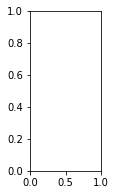

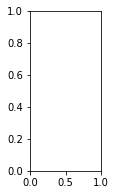

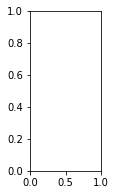

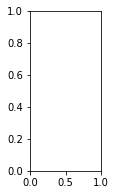

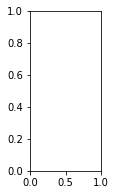

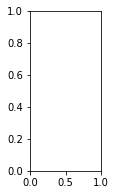

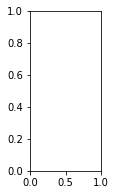

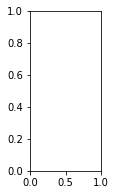

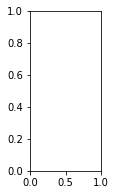

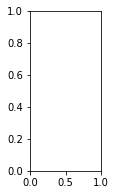

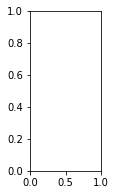

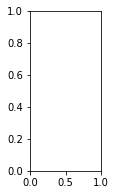

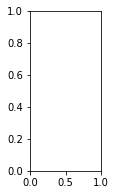

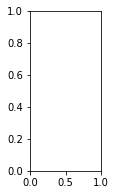

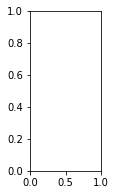

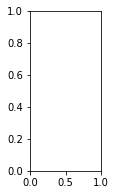

In [70]:
for index, code_num in enumerate(facs_pred_df.columns):
    plt.figure(figsize=(15,10))
    plt.subplot(3,10,index+1)

    print('AU ',code_num)
    print(confusion_matrix(facs_test_arranged[code_num], facs_pred_df[code_num]))

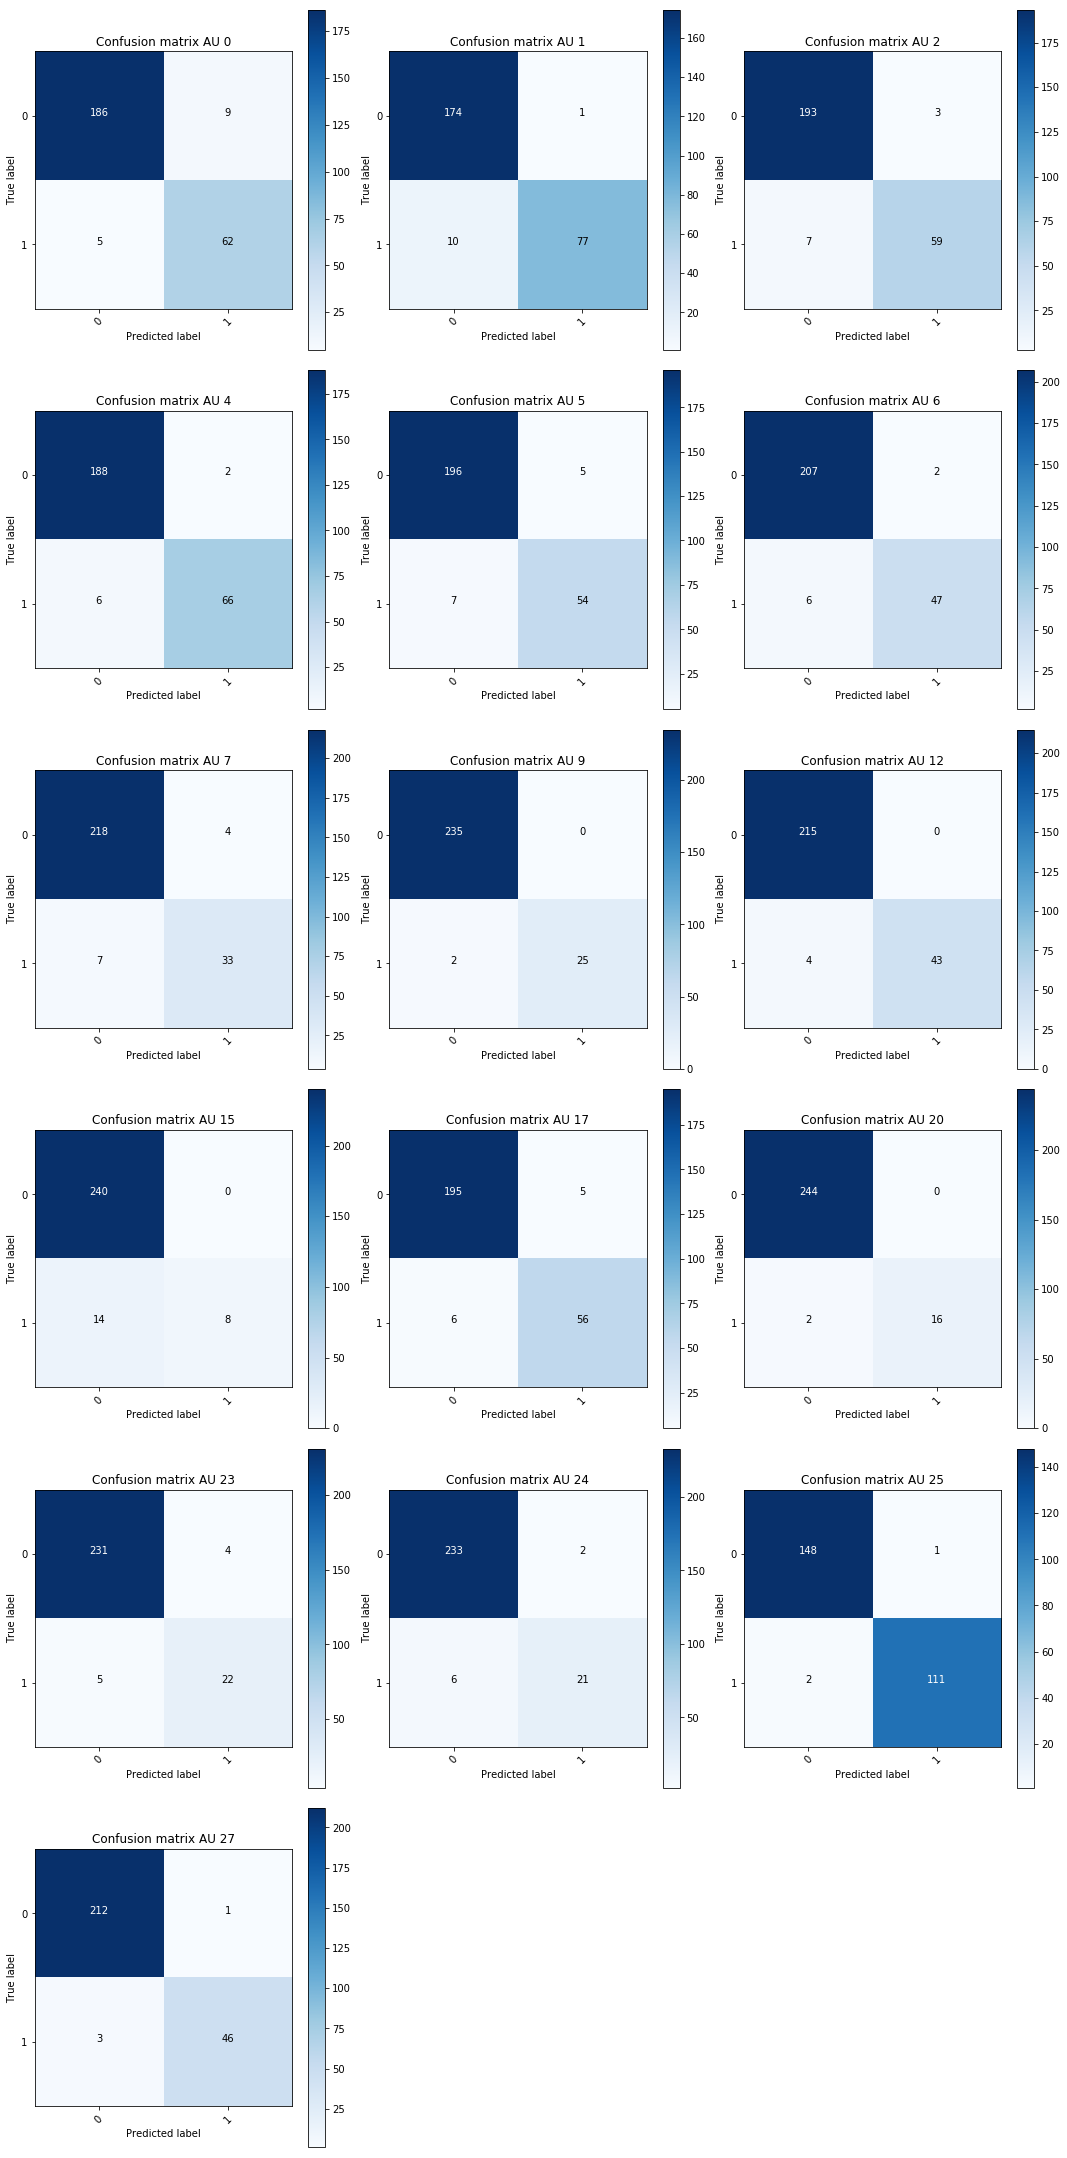

In [85]:
import itertools
class_names = [0, 1]
plt.figure(figsize=(15,50))
for index, code_num in enumerate(facs_pred_df.columns):
    plt.subplot(10,3,index+1)
    cnf_matrix = confusion_matrix(facs_test_arranged[code_num], facs_pred_df[code_num])
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix AU '+str(code_num))

#     print('AU ',code_num)
#     print(confusion_matrix(facs_test_arranged[code_num], facs_pred_df[code_num]))

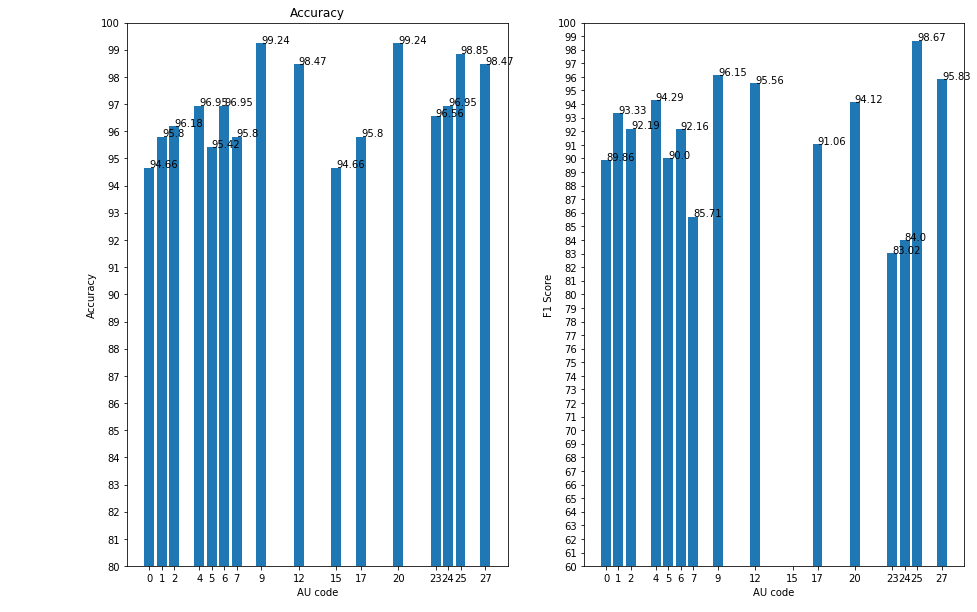

In [61]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('AU code')
plt.ylabel('Accuracy')
plt.xticks(facs_acc_percent.index)
plt.ylim((80,100))
plt.yticks(np.arange(80,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['Accuracy'])
for i,j in zip(list(facs_acc_percent.index), facs_acc_percent['Accuracy']):
    j = round(j, 2)
    ax.annotate(str(j),xy=(i,j))


ax = plt.subplot(1,2,2)
plt.xlabel('AU code')
plt.ylabel('F1 Score')
plt.xticks(facs_acc_percent.index)
plt.ylim((60,100))
plt.yticks(np.arange(60,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['f1_score'])
for i,j in zip(list(facs_acc_percent.index), facs_acc_percent['f1_score']):
    j = round(j, 2)
    ax.annotate(str(j),xy=(i,j))

In [213]:
facs_acc_percent.to_csv('result/feature_au_acc.csv')

<Container object of 18 artists>

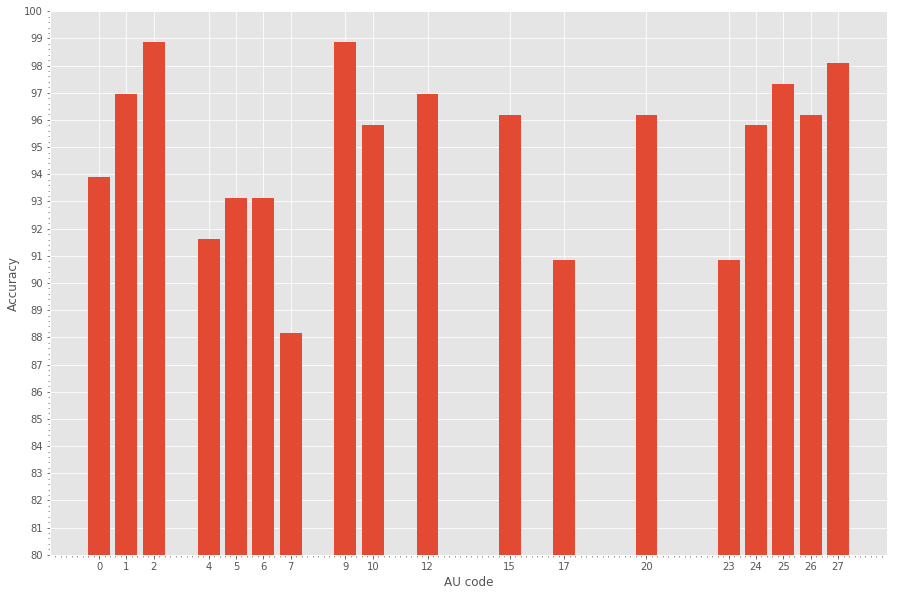

In [128]:
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
plt.ylabel('Accuracy')
plt.xlabel('AU code')
plt.minorticks_on()
plt.xticks(facs_acc_percent.index)
plt.ylim((80,100))
plt.yticks(np.arange(80,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['Accuracy'])

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
rfc = RandomForestClassifier()

In [59]:
rfc.fit(feature_train, facs_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
facs_pred = rfc.predict(feature_test)

In [67]:
facs_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [69]:
facs_test.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [75]:
correct = {}
for inst in range(facs_pred.shape[0]):
    for elem in range(facs_pred.shape[1]):
        if not elem in correct:
            correct[elem] = 0
        if facs_pred[inst][elem] == facs_test.values[inst][elem] and facs_pred[inst][elem] == 1:
            correct[elem] += 1
print(list(map(lambda x : x / facs_pred.shape[0], correct)))

[0.0, 0.003816793893129771, 0.007633587786259542, 0.011450381679389313, 0.015267175572519083, 0.019083969465648856, 0.022900763358778626, 0.026717557251908396, 0.030534351145038167, 0.03435114503816794, 0.03816793893129771, 0.04198473282442748, 0.04580152671755725, 0.04961832061068702, 0.05343511450381679, 0.05725190839694656, 0.061068702290076333, 0.0648854961832061]


## (300,)

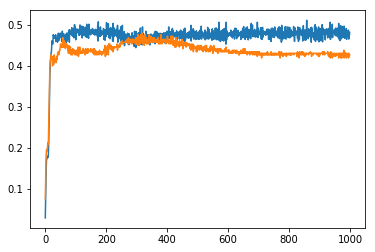

In [49]:
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## (1000,)

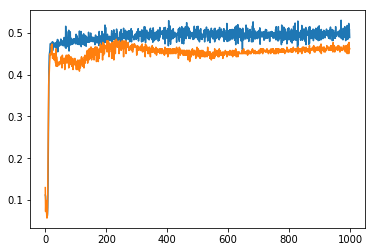

In [53]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## (1000, 500)

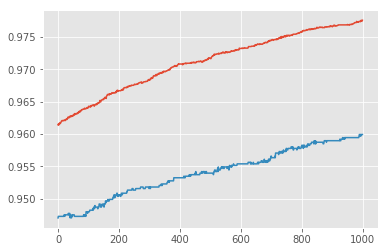

In [165]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])